# Analysis of Films

## Overview

The purpose of this project is to analyze the trends in the movie industry and give reccommendations base on these initial findings to new studis. Exploratory analysis reveals the average ROI of ##, runtime averging closer to 2 hours, and action with other genres included produced the most revenue per movie. Microsoft can use the analysis made here to aid have a sense on they type of movies they should aim for in their new movie studio.

## Business Problem

Microsoft can venture into the movie industry by creating a movie studio under their name. The issue is that Microsoft may be unfamilar with where to being in the production of new films. With some insight into the landscape of the movie industry such as how much money others are investing per movie, the length of movies and the type of genres that produce high gross per movie, Microsoft will be able produce films that are profitable. This project decribes the trends in return of investment, movie length over time and top genres.

## Data Understanding

The data comes from multiple sources. In this project, data from the the box office, tmdb, tn and IMDB was used. Each data file had the name of the film in which merges occurred on as they each had an column of interest for the analysis. The data provide the production budget, worldwide gross, runtime and other features of a film that may be of interest. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import sqlite3
import zipfile as zf
import os
#pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [3]:
tmdb = pd.read_csv('./data/tmdb.movies.csv.gz')
tn = pd.read_csv('./data/tn.movie_budgets.csv.gz')


In [4]:
files = zf.ZipFile('./data/im.db.zip', 'r') #opens the zip file
files.extractall() #creates a im.db file which is too big to push
con = sqlite3.connect("./im.db")

#turning the sql dataset into a dataframe
titles = pd.read_sql("""Select * From movie_basics """, con)

Examination of each dataset for columns of interest. 

In [5]:
tmdb.head(1)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788


In [6]:
tn.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


In [7]:

titles.head(1)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


In [8]:
rating = pd.read_sql("""Select * From movie_ratings""", con)

rating.head(1)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31


We identify these columns of interests:
- studio columns from the bom dataset
- popularity, release_date, vote_avergae and vote_count columns from the tmdb
- runtime_minutes, genre, averagerating, and numvotes from two sql dataset that requires merging on the movie special identification 

## Data Preparation

### Initial Data Merging

We merge the BOM and the tmdb dataset, then merged it that to the tn data set to have most of our columns of interest. The two sql data set were then merged together.

In [9]:
#creation of the merged table betweeen bom and tmdb
#rating_and_gross = bom.merge(tmdb, how='inner', left_on='title', right_on='title').sort_values('domestic_gross', ascending=False)

In [10]:
#creation of merge table of the rating_and_gross with the tn table
budget_rating_gross = tmdb.merge(tn, how='inner', left_on='title', right_on='movie')

In [11]:
#Merging of the two sql data bases
sql_df = pd.read_sql('''
    SELECT *
    
    FROM
    movie_ratings
    
    INNER JOIN movie_basics
        USING(movie_id) 
     
     WHERE numvotes >= 1000
     
     ORDER BY 
         averagerating DESC
''', con)

In [12]:
budget_rating_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2385 non-null   int64  
 1   genre_ids          2385 non-null   object 
 2   id_x               2385 non-null   int64  
 3   original_language  2385 non-null   object 
 4   original_title     2385 non-null   object 
 5   popularity         2385 non-null   float64
 6   release_date_x     2385 non-null   object 
 7   title              2385 non-null   object 
 8   vote_average       2385 non-null   float64
 9   vote_count         2385 non-null   int64  
 10  id_y               2385 non-null   int64  
 11  release_date_y     2385 non-null   object 
 12  movie              2385 non-null   object 
 13  production_budget  2385 non-null   object 
 14  domestic_gross     2385 non-null   object 
 15  worldwide_gross    2385 non-null   object 
dtypes: float64(2), int64(4),

There are 195 null values in the foreign_gross column, 2 in the domestic_gross_x column, and 1 in studio column.
There are unnecessary columns. 

### Initial Data Cleaning

We dropped columns that we thought were not useful for our analysis. Then monetary values were converted from strings to integers to be used, dropped exact duplicates and duplicates where the movie title was the same but some values were incorrect.

In [13]:
#dropping unnecessary columns
clean_columns = budget_rating_gross.drop(['release_date_y', 'Unnamed: 0', 'genre_ids', 'original_title', 'movie', 'id_x', 'id_y', 'original_language'], axis=1)
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   popularity         2385 non-null   float64
 1   release_date_x     2385 non-null   object 
 2   title              2385 non-null   object 
 3   vote_average       2385 non-null   float64
 4   vote_count         2385 non-null   int64  
 5   production_budget  2385 non-null   object 
 6   domestic_gross     2385 non-null   object 
 7   worldwide_gross    2385 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 167.7+ KB


In [14]:
#cleaning and converting worldwide_gross into int
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace('$', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace(',', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].astype('int64')

In [15]:
##cleaning and converting domestic_gross_y into int
clean_columns['domestic_gross'] = clean_columns['domestic_gross'].str.replace('$', '')
clean_columns['domestic_gross'] = clean_columns['domestic_gross'].str.replace(',', '')
clean_columns['domestic_gross'] = clean_columns['domestic_gross'].astype('int64')

In [16]:
#cleaning and converting production_budget into int
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace('$', '')
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace(',', '')
clean_columns['production_budget'] = clean_columns['production_budget'].astype('int64')

In [17]:
#Sanity Check
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   popularity         2385 non-null   float64
 1   release_date_x     2385 non-null   object 
 2   title              2385 non-null   object 
 3   vote_average       2385 non-null   float64
 4   vote_count         2385 non-null   int64  
 5   production_budget  2385 non-null   int64  
 6   domestic_gross     2385 non-null   int64  
 7   worldwide_gross    2385 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 167.7+ KB


In [18]:
#dropping exact row duplicates
test_clean_columns = clean_columns.drop_duplicates()

In [19]:
#dropping duplicates where the title name is the same but other values are wrong
vote_count_max = test_clean_columns.groupby(['title']).vote_count.transform(max)
movies_clean = test_clean_columns.loc[test_clean_columns.vote_count == vote_count_max]

In [20]:
#Sanity Check: verifying the shape of movies_clean
movies_clean.shape

(1985, 8)

After cleaning the dataset, we then merge the movies_clean with the sql_df to finally have all the columns of interest for the individual films that will be used later on.

In [21]:
movies_sql = movies_clean.merge(sql_df, how='inner', left_on='title', right_on='original_title')

# Data Analyzation

We want to see what the initial data was telling us without the removal of outliers and to identify any anomaly.

In [22]:
#Quick glance at the information of the dataset
movies_clean.describe()
# min value for production_budget is > 0.

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross
count,1985.000000,1985.000000,1985.000000,1.985000e+03,1.985000e+03,1.985000e+03
mean,11.109711,6.183929,1750.817128,3.814160e+07,4.886928e+07,1.192009e+08
std,8.118948,1.076845,2716.246973,5.154858e+07,8.055328e+07,2.207352e+08
min,0.600000,0.000000,1.000000,9.000000e+03,0.000000e+00,0.000000e+00
25%,6.330000,5.600000,97.000000,5.000000e+06,8.903030e+05,3.237452e+06
50%,9.839000,6.200000,692.000000,2.000000e+07,2.073872e+07,3.711936e+07
75%,14.585000,6.800000,2147.000000,4.800000e+07,5.826915e+07,1.236967e+08
max,80.773000,10.000000,22186.000000,4.250000e+08,7.605076e+08,2.776345e+09


After a quick skim from above, we notice that there is some outliers with our dataset. Not only that, but that we want to ensure that we're capturing data that only has worldwide gross gives us a sense of how much was made domestically and overseas combined. 

In [23]:
movies_clean['gross_to_budget_ratio'] = movies_clean['worldwide_gross'] / movies_clean['production_budget']

<ipython-input-23-b7aabc6df952>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_clean['gross_to_budget_ratio'] = movies_clean['worldwide_gross'] / movies_clean['production_budget']


In [24]:
#Dropping outliers from worldwide_gross
q3, q1 = np.percentile(movies_clean['worldwide_gross'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_wwg = movies_clean['worldwide_gross'].mean()-(iqr*1.5)

upper_limit_wwg = movies_clean['worldwide_gross'].mean()+(iqr*1.5)

lower_limit_wwg, upper_limit_wwg

(-61488042.26423174, 299889824.73576826)

In [25]:
movies_without_wwg_outliers = movies_clean[movies_clean['worldwide_gross']<upper_limit_wwg]

We expect some form revenue for domestic if it was released in theatres. Some other reasoning

In [26]:
#Dropping outliers from production_budget
q3, q1 = np.percentile(movies_without_wwg_outliers['production_budget'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_pb = movies_without_wwg_outliers['production_budget'].mean()-(iqr*1.5)

upper_limit_pb = movies_without_wwg_outliers['production_budget'].mean()+(iqr*1.5)

lower_limit_pb, upper_limit_pb

(-21004391.479225952, 71995608.52077405)

In [27]:
movies_without_wwg_or_pb_outliers = movies_without_wwg_outliers[movies_without_wwg_outliers['production_budget']<upper_limit_pb]

We decided to create three different variables that had remove outliers. These variables excluded the outliers base on the iqr formula for determining outliers. These variables looked at outliers base on just worldwide_gross, and worldwide_gross plus production_budget outliers.

### Production Budget

We started examining the question of what is the ROI for a movie and how strong of a correlation is there between the production budget and their total gross.

In [28]:
clean_columns['gross_to_budget_ratio'] = clean_columns['worldwide_gross'] / clean_columns['production_budget']


In [29]:
#get a sense of what the averages, medians and range are
clean_columns.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,gross_to_budget_ratio
count,2385.000000,2385.000000,2385.000000,2.385000e+03,2.385000e+03,2.385000e+03,2385.000000
mean,10.423104,6.202474,1662.224738,3.772410e+07,4.948916e+07,1.199040e+08,4.314094
std,8.257018,1.184930,2681.183078,5.125635e+07,8.275210e+07,2.213221e+08,14.217350
min,0.600000,0.000000,1.000000,9.000000e+03,0.000000e+00,0.000000e+00,0.000000
25%,4.749000,5.600000,48.000000,5.000000e+06,8.818240e+05,3.187302e+06,0.428868
50%,9.329000,6.300000,563.000000,1.900000e+07,2.015730e+07,3.704853e+07,1.777859
75%,14.239000,6.900000,2047.000000,4.500000e+07,5.789180e+07,1.233688e+08,3.894215
max,80.773000,10.000000,22186.000000,4.250000e+08,7.605076e+08,2.776345e+09,416.564740


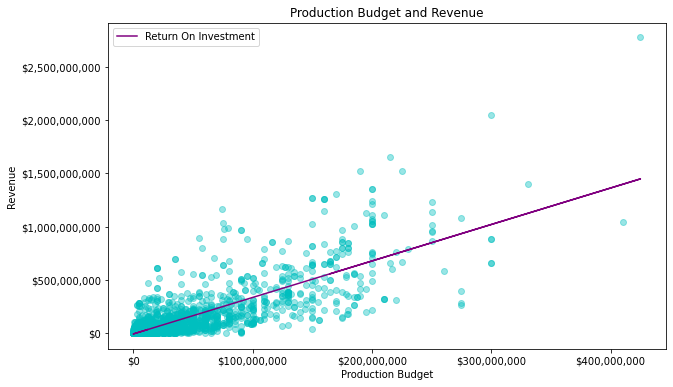

In [30]:
#graph of it with outliers included
fig, ax = plt.subplots(figsize=(10,6))
ax.ticklabel_format(style='plain')
ax.scatter(clean_columns['production_budget'] , y = clean_columns['worldwide_gross'], alpha = .4, c="c");

x=clean_columns['production_budget']
y=clean_columns['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])

ax.set_title('Production Budget and Revenue')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.savefig('./Untitled Folder/Production Budget and Worldwide Gross with outliers.png', bbox_inches = 'tight');

In [31]:
np.corrcoef(clean_columns['production_budget'] , y = clean_columns['worldwide_gross'])[0][1]

0.7941073908765615

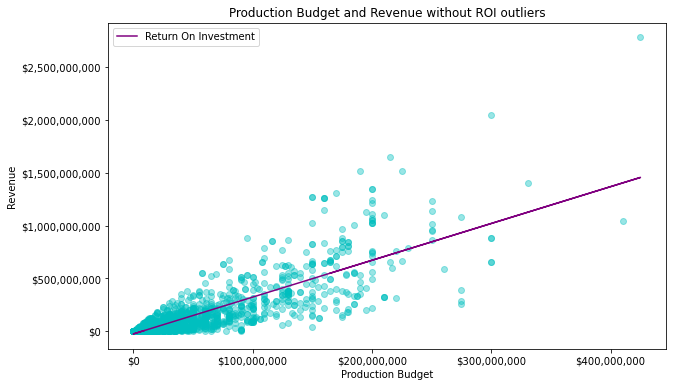

In [32]:
# determining outliers
q3, q1 = np.percentile(clean_columns['gross_to_budget_ratio'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit = clean_columns['gross_to_budget_ratio'].mean()-(iqr*1.5)

upper_limit = clean_columns['gross_to_budget_ratio'].mean()+(iqr*1.5)

lower_limit, upper_limit

#limiting data to the upper limit of the iqr
movies_oultierless = clean_columns[clean_columns['gross_to_budget_ratio']<upper_limit]


#graph of movies_oultierless
fig, ax = plt.subplots(figsize=(10,6))
ax.ticklabel_format(style='plain')
ax.scatter(movies_oultierless['production_budget'] , y = movies_oultierless['worldwide_gross'], alpha = .4, c="c");

x=movies_oultierless['production_budget']
y=movies_oultierless['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])


ax.set_title('Production Budget and Revenue without ROI outliers')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.savefig('./Untitled Folder/Production Budget and Worldwide Gross outlierless.png', bbox_inches = 'tight');

In [33]:
#get a sense of what the averages, medians and range are
movies_oultierless.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,gross_to_budget_ratio
count,2203.000000,2203.000000,2203.000000,2.203000e+03,2.203000e+03,2.203000e+03,2203.000000
mean,10.268095,6.177167,1568.694054,3.989318e+07,4.649623e+07,1.143247e+08,2.145045
std,8.205911,1.177364,2600.404520,5.250343e+07,8.063926e+07,2.192076e+08,2.152240
min,0.600000,0.000000,1.000000,9.000000e+03,0.000000e+00,0.000000e+00,0.000000
25%,4.519000,5.600000,46.000000,6.000000e+06,5.665755e+05,2.322505e+06,0.335776
50%,9.149000,6.200000,509.000000,2.000000e+07,1.755087e+07,3.283894e+07,1.554199
75%,13.900500,6.900000,1896.000000,5.000000e+07,5.457879e+07,1.123083e+08,3.222996
max,80.773000,10.000000,22186.000000,4.250000e+08,7.605076e+08,2.776345e+09,9.496621


In [34]:
#Removed outliers based on gross_to_budget_ratio. The correlation was very strong and positive.
np.corrcoef(movies_oultierless['production_budget'] , y = movies_oultierless['worldwide_gross'])[0][1]
#almost a 1:1 correlation

0.8333772111615128

A stronger correlation compared to when outliers were included. It looks to be very close to 1:1 relationship. 

In [35]:
#get a sense of what the averages, medians and range are
movies_without_wwg_or_pb_outliers.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,gross_to_budget_ratio
count,1628.000000,1628.000000,1628.000000,1.628000e+03,1.628000e+03,1.628000e+03,1628.000000
mean,9.164849,6.115418,1001.084767,1.874471e+07,2.390938e+07,4.525875e+07,3.875295
std,6.110952,1.100462,1501.466869,1.806589e+07,3.182708e+07,5.952591e+07,15.426563
min,0.600000,0.000000,1.000000,9.000000e+03,0.000000e+00,0.000000e+00,0.000000
25%,5.517250,5.500000,61.000000,3.500000e+06,2.144182e+05,1.224814e+06,0.248990
50%,8.820500,6.200000,440.500000,1.300000e+07,1.075855e+07,2.051552e+07,1.438261
75%,12.314500,6.800000,1312.500000,3.000000e+07,3.666259e+07,6.735383e+07,3.300917
max,78.123000,10.000000,19673.000000,7.168298e+07,2.422125e+08,2.989234e+08,416.564740


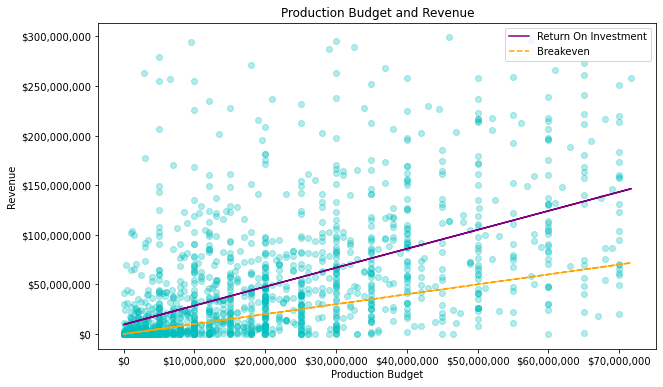

In [36]:
#graph of movies_without_wwg_or_pb_outliers
fig, ax = plt.subplots(figsize=(10,6),)
ax.ticklabel_format(style='plain')
ax.scatter(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'], alpha = .3, c="c")


x=movies_without_wwg_or_pb_outliers['production_budget']
y=movies_without_wwg_or_pb_outliers['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'], )

plt.plot(x, x, c="orange", ls="--")
plt.legend(['Return On Investment', 'Breakeven'])

ax.set_title('Production Budget and Revenue')

ax.set_xlabel('Production Budget')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) #adds commas to the int value
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.savefig('./Untitled Folder/Production Budget and Worldwide Gross without wwg or pb.png', bbox_inches = 'tight');

In [37]:
#checking the correlation coefficient of movies_without_wwg_or_pb_outliers
np.corrcoef(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'])[0][1]
#postive correlation but not as strong as the movie_oultierless

0.5797758751480752

The correlation for movies_without_wwg_or_pb_outliers is positive and decent but not as strong as movie_oultierless.

### Movie Genre

We decided to measrure genre success we used our worldwide gross data. We didn't use average rating or number of votes to measure success because it was difficult to make a reccomendation based on average rating isn't very significant and it is difficult to measure success on the number of votes a movie has recieved. 

In [59]:
genres_numvotes = sql_df.groupby(['genres']).mean(['numvotes']).sort_values(['numvotes'], ascending=False).head(10)
genres_numvotes
#Low vote counts can skew the rating much more
#This code wasn't used to measure success
#This code was used to determine the cut off limit for our sql data using 1000 for numvotes above.

,averagerating,numvotes,start_year,runtime_minutes
genres,,,,
"Adventure,Drama,Sci-Fi",7.400000,661338.666667,2015.666667,137.000000
"Adventure,Mystery,Sci-Fi",7.000000,538720.000000,2012.000000,124.000000
"Action,Adventure,Sci-Fi",6.184416,298904.454545,2014.649351,121.168831
"Adventure,Fantasy",7.050000,282334.750000,2014.250000,132.500000
"Action,Fantasy,War",6.200000,262978.000000,2014.000000,102.000000
"Family,Fantasy,Musical",7.200000,238325.000000,2017.000000,129.000000
"Adventure,Fantasy,Mystery",6.500000,214947.500000,2012.000000,136.500000
"Action,Adventure,Mystery",6.675000,181746.250000,2013.250000,124.750000
"Adventure,Drama,Fantasy",6.085714,175524.500000,2014.357143,111.571429


Text(0.5, 0, 'Number of Votes')

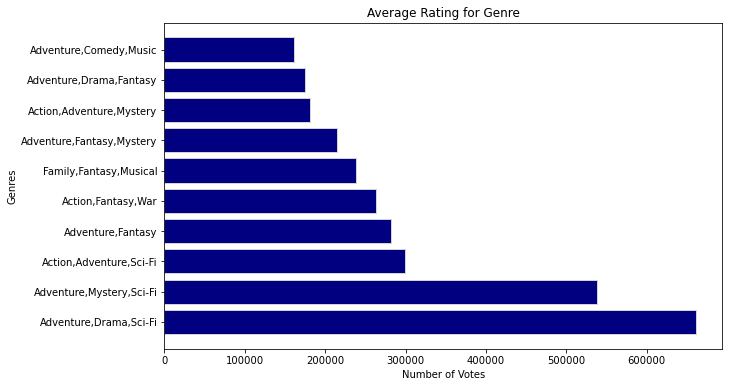

In [60]:
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=genres_numvotes.index, width=genres_numvotes['numvotes'], color="navy", edgecolor="lightgrey")
ax.set_title('Average Rating for Genre')
ax.set_ylabel('Genres')
ax.set_xlabel('Number of Votes')

In [51]:
#genres vs averagerating
genres_average_rating = sql_df.groupby(['genres']).mean(['averagerating']).sort_values(['averagerating'], ascending=False).head(10)
genres_average_rating
#Low vote counts can skew the rating much more
#This code was used to determine the cut off limit for our sql data using 1000 for numvotes above.
#We didn't use averagerating or numvotes to measure success because it was difficult to make a reccomendation. 


,averagerating,numvotes,start_year,runtime_minutes
genres,,,,
"Action,Romance,War",8.500000,1224.000000,2018.000000,130.000000
"Animation,History",8.300000,7451.000000,2014.000000,135.000000
"Drama,Family,Thriller",8.300000,2996.000000,2014.000000,150.000000
"Animation,Documentary,Mystery",8.200000,1014.000000,2017.000000,93.000000
War,8.200000,2437.000000,2011.000000,96.000000
Musical,8.180000,1724.000000,2014.800000,120.800000
"Biography,Documentary,News",8.100000,7848.000000,2015.000000,73.000000
"Documentary,History,Sport",8.033333,1889.333333,2015.333333,103.000000
"Documentary,Family",8.000000,2662.333333,2013.000000,89.333333


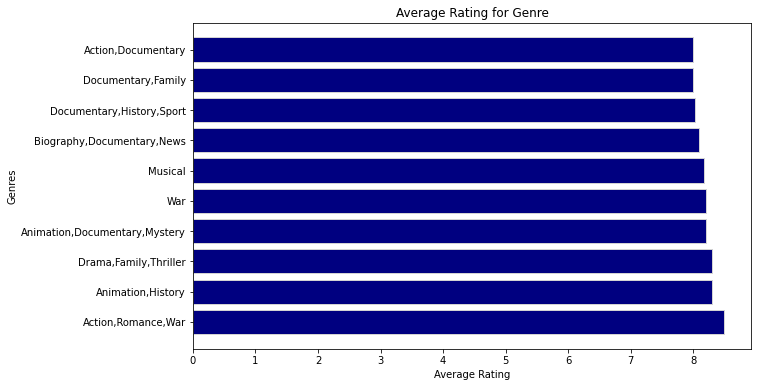

In [52]:
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=genres_average_rating.index, width=genres_average_rating['averagerating'], color="navy", edgecolor="lightgrey")
ax.set_title('Average Rating for Genre')
ax.set_ylabel('Genres')
ax.set_xlabel('Average Rating')


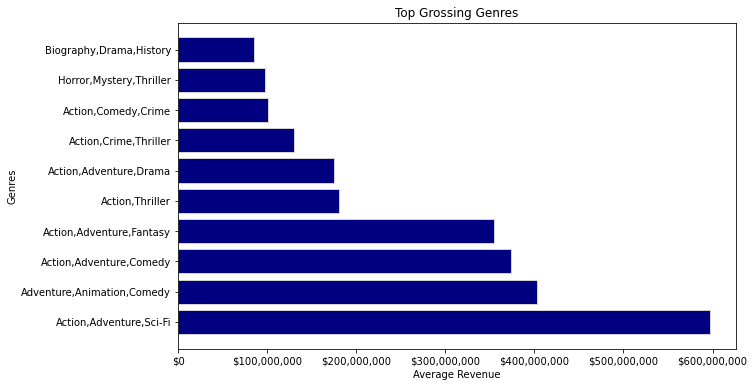

In [54]:
#graph of genre v average worldwide_gross

genres_list = pd.get_dummies(movies_sql.genres, prefix=None).sum().sort_values(ascending=False).head(20)
genres_list2 = list(genres_list.index)
movies_sql2 = movies_sql[movies_sql['genres'].isin(genres_list2)]
#movies_sql2['worldwide_gross_mil'] = movies_sql2['worldwide_gross']/1000000 might not need this
genres_vs_wwg = movies_sql2.groupby(['genres']).mean().sort_values(['worldwide_gross'], ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=genres_vs_wwg.index, width=genres_vs_wwg['worldwide_gross'], color="navy", edgecolor="lightgrey")
ax.set_title('Top Grossing Genres')
ax.set_ylabel('Genres')
ax.set_xlabel('Average Revenue')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.savefig('./Untitled Folder/Top Grossing Genres.png', bbox_inches = 'tight');

We see that the 6 of the top 10 genre combination have action in it. Also, we notice how movies that are just list as action without any other genres includes do no make anywhere as much as some of these other combination.

### Runtime

We wanted to see if there's any trend in terms of movie lengths over the year, and any correlation between how much money is made with the length of the movie.

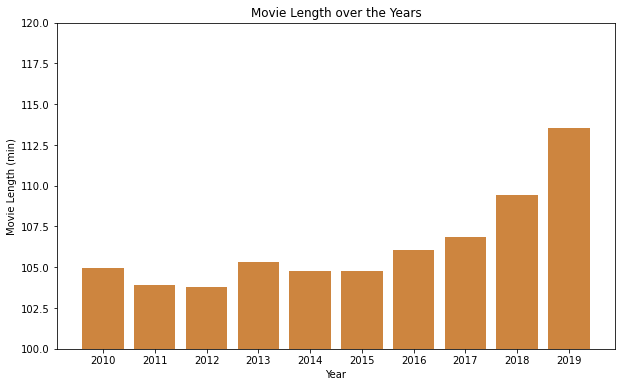

In [126]:
#runtime_minutes vs start_year
runtime_year = sql_df.groupby(['start_year']).mean(['runtime_minutes']).sort_values(['start_year'])
runtime_year

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(x=runtime_year.index.astype(str), height=(runtime_year['runtime_minutes']), color="peru");
ax.set_ylim([100, 120])
#Started our chart with the y axis starting at 100 for visual purposes.

ax.set_title('Movie Length over the Years')
ax.set_xlabel('Year')
ax.set_ylabel('Movie Length (min)')
plt.savefig('./Untitled Folder/Movie Length over the Years.png', bbox_inches = 'tight');

In [127]:
#testing correlation between year and movie length
np.corrcoef(runtime_year.index , y = runtime_year['runtime_minutes'])[0][1]

0.810556758544068

Movies are getting longer throughout the years.

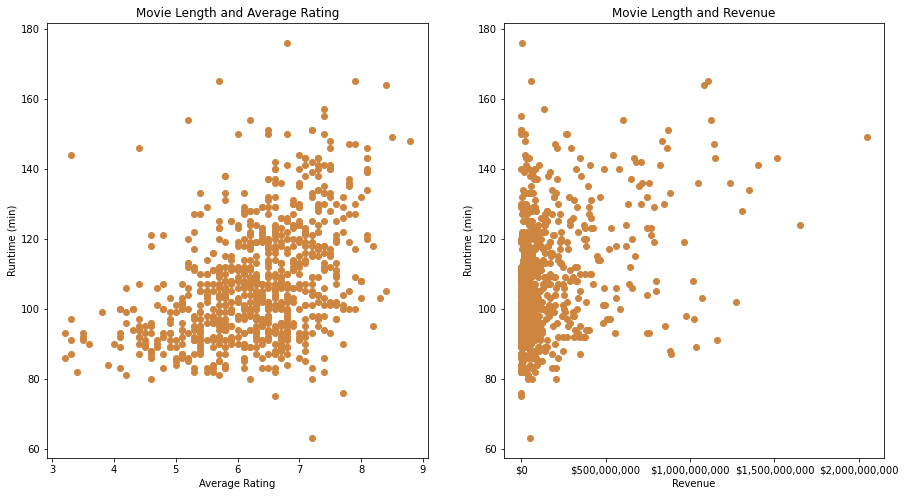

In [128]:
#graphing the averagerating to movie length and movie length with the wwg
fig, (ax1, ax2) = plt.subplots(figsize=(15,8), ncols=2)

ax1.ticklabel_format(style='plain')
ax1.scatter(movies_sql2['averagerating'] , y = movies_sql2['runtime_minutes'], color="peru");

ax2.ticklabel_format(style='plain')
ax2.scatter(movies_sql2['worldwide_gross'] , y = movies_sql2['runtime_minutes'], color="peru");

ax1.set_title('Movie Length and Average Rating')
ax2.set_title('Movie Length and Revenue')
ax1.set_ylabel('Runtime (min)')
ax2.set_ylabel('Runtime (min)')
ax1.set_xlabel('Average Rating')
ax2.set_xlabel('Revenue')
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.savefig('./Untitled Folder/Movie Length Average Rating and Worldwide Gross.png', bbox_inches = 'tight');

In [129]:
Worldwide_Gross_Run_Time_Correlation = np.corrcoef(movies_sql2['worldwide_gross'] , y = movies_sql2['runtime_minutes'])
Average_Rating_Run_Time_Correlation = np.corrcoef(movies_sql2['averagerating'] , y = movies_sql2['runtime_minutes'])

Worldwide_Gross_Run_Time_Correlation[0][1], Average_Rating_Run_Time_Correlation[0][1]


(0.34872802124086016, 0.4302111428774885)

The correlation is pretty weak that we can safely say that movie length won't affect the amount of revenue made.

In [130]:
con.close() #have this in the extracted file refuses to close

In [131]:
os.remove('im.db') #This line deletes the im.db file created earlier.

## Evaluation

The median production budget is about $37 million with about a ROI of 1.77x. When we factor in outliers that exist in the data in the worldwide_gross and production budget, we find that the cost is $20 million with ROI of 1.4x.The runtime is not strongly correlated with worldwide_gross but since the films are trending towards about 2 hours, we reccommend films be around two hours.
The top 4 genres combination are:
- Action, Adventure, Sci-Fi
- Action, Adventure, Comedy
- Adventure, Animation, Comedy
- Action, Adventure, Fantasy

## Next Steps

After these findings, it would be in the interest of Microsoft to find how much money is being invested into advertising the movie and where they are being advertised (online versus cable). Not only that but look at how hiring known actors and directors impact the ROI compared to the price to hire them.